In [1]:
import os
import numpy as np
import pandas as pd
import tqdm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from typing import Sequence


## 全局变量

In [2]:
COMPANY = 101410010  # @param { isTemplate: true, type: 'string'}
LOSS = 'ziln'  # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
MODEL = 'linear'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param {type: 'integer'}
OUTPUT_CSV_FOLDER = r'D:\github_repo_forked\lifetime_value\result'  # @param { isTemplate: true, type: 'string'}

In [3]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## 加载数据

In [4]:
def load_customer_level_csv(company):
  customer_level_data_file = (
      r'D:\github_repo_forked\lifetime_value\acquire-valued-shoppers-challenge\customer_level_data_company_{}.csv'
      .format(company))
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    print('请先使用preprocess.py进行预处理')
    return
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

In [5]:
customer_level_data = load_customer_level_csv(COMPANY)

<Axes: >

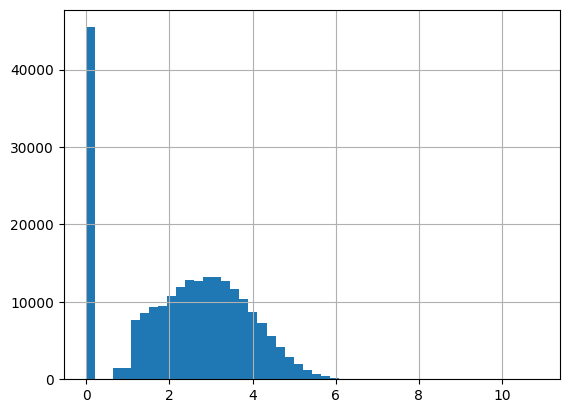

In [6]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

In [7]:
customer_level_data.head().T

,0,1,2,3,4
id,86246,86252,12262064,12277270,12332190
calibration_value,3.99,4.49,3.39,2.99,1.99
chain,205,205,95,95,95
dept,9,9,9,9,9
category,907,912,905,910,902
brand,13791,13791,13791,13791,45039
productmeasure,OZ,OZ,OZ,OZ,OZ
holdout_value,83.080002,179.410004,6.98,6.79,0.0
log_calibration_value,1.383791,1.501853,1.22083,1.095273,0.688135
label,83.08,179.41,6.98,6.79,0.0


## 数据集划分

In [8]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
  y = df['label'].values
  y0 = df['calibration_value'].values

  x_train, x_eval, y_train, y_eval, y0_train, y0_eval = (
      model_selection.train_test_split(
          x, y, y0, test_size=0.2, random_state=123))

  return x_train, x_eval, y_train, y_eval, y0_eval

In [9]:
def dnn_split(df):
    for key in CATEGORICAL_FEATURES:
        encoder = preprocessing.LabelEncoder()
        df[key] = encoder.fit_transform(df[key])

    y0 = df['calibration_value'].values
    df_train, df_eval, y0_train, y0_eval = model_selection.train_test_split(
    df, y0, test_size=0.2, random_state=123)
  

    def feature_dict(df):
        features = {k: torch.tensor(v.values) for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
        features['numeric'] = torch.tensor(df[NUMERIC_FEATURES].values)
        return features

    x_train, y_train = feature_dict(df_train), df_train['label'].values
    x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values
    return x_train, x_eval, y_train, y_eval, y0_eval

## Model

In [10]:
import torch.nn as nn

def linear_model(input_dim, output_units):
    return nn.Linear(input_dim, output_units)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def embedding_dim(x):
    return int(x**0.25) + 1

class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim(vocab_size))
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        return x

class DNNModel(nn.Module):
    def __init__(self, output_units, df):
        super(DNNModel, self).__init__()
        self.numeric_input = nn.Linear(len(NUMERIC_FEATURES), 64)
        self.embedding_layers = nn.ModuleList([
            EmbeddingLayer(df[key].nunique()) for key in CATEGORICAL_FEATURES
        ])
        # 计算每个嵌入层的维度
        embedding_dims = [embedding_dim(df[feature].nunique()) for feature in CATEGORICAL_FEATURES]
        # 计算总的嵌入维度
        total_embedding_dim = sum(embedding_dims)
        # 第一个线性层的输入维度
        input_dim = 64 + total_embedding_dim
        self.deep_model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_units)
        )

    def forward(self, numeric_input, *embedding_inputs):
        numeric_output = F.relu(self.numeric_input(numeric_input))
        embedding_outputs = [layer(input) for layer, input in zip(self.embedding_layers, embedding_inputs)]
        deep_input = torch.cat([numeric_output] + embedding_outputs, dim=1)
        output = self.deep_model(deep_input)
        return output


## Train


In [12]:
import torch.nn as nn
import sys
sys.path.append(r'D:\github_repo_forked\lifetime_value')
from lifetime_value_pytorch.zero_inflated_lognormal import zero_inflated_lognormal_loss
if LOSS == 'mse':
    loss_fn = nn.MSELoss()
    output_units = 1

if LOSS == 'ziln':
    loss_fn = zero_inflated_lognormal_loss
    output_units = 3

In [13]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval, y0_eval = linear_split(customer_level_data)
  input_dimension = x_train.shape[1]
  print(input_dimension)
  model = linear_model(input_dimension,output_units)

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval, y0_eval = dnn_split(customer_level_data)
  model = DNNModel(output_units, customer_level_data)
  print(model)

143


Epoch 1/400, Train Loss: 10.2197, Val Loss: 9.3211
Epoch 2/400, Train Loss: 8.6264, Val Loss: 8.0452
Epoch 3/400, Train Loss: 7.5702, Val Loss: 7.1710
Epoch 4/400, Train Loss: 6.8297, Val Loss: 6.5434
Epoch 5/400, Train Loss: 6.2888, Val Loss: 6.0766
Epoch 6/400, Train Loss: 5.8808, Val Loss: 5.7195
Epoch 7/400, Train Loss: 5.5650, Val Loss: 5.4397
Epoch 8/400, Train Loss: 5.3154, Val Loss: 5.2166
Epoch 9/400, Train Loss: 5.1146, Val Loss: 5.0356
Epoch 10/400, Train Loss: 4.9507, Val Loss: 4.8869
Epoch 11/400, Train Loss: 4.8151, Val Loss: 4.7631
Epoch 12/400, Train Loss: 4.7018, Val Loss: 4.6589
Epoch 13/400, Train Loss: 4.6061, Val Loss: 4.5707
Epoch 14/400, Train Loss: 4.5245, Val Loss: 4.4952
Epoch 15/400, Train Loss: 4.4544, Val Loss: 4.4300
Epoch 16/400, Train Loss: 4.3936, Val Loss: 4.3733
Epoch 17/400, Train Loss: 4.3406, Val Loss: 4.3237
Epoch 18/400, Train Loss: 4.2940, Val Loss: 4.2800
Epoch 19/400, Train Loss: 4.2529, Val Loss: 4.2413
Epoch 20/400, Train Loss: 4.2163, Val L

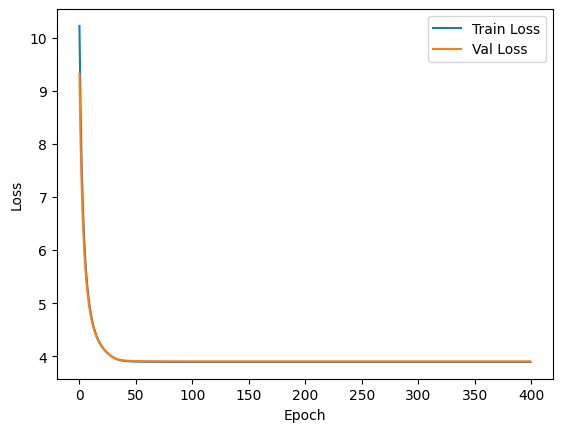

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 假设你已经定义了模型、损失函数和优化器
criterion = loss_fn
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 创建数据加载器
if MODEL == 'linear':
    train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    eval_dataset = TensorDataset(torch.Tensor(x_eval), torch.Tensor(y_eval))

if MODEL == 'dnn':
    train_dataset = TensorDataset(x_train['numeric'], *[x_train[key] for key in CATEGORICAL_FEATURES], torch.Tensor(y_train))
    eval_dataset = TensorDataset(x_eval['numeric'], *[x_eval[key] for key in CATEGORICAL_FEATURES], torch.Tensor(y_eval))
# 检查 train_dataset 和 eval_dataset 是否已定义
if train_dataset is None or eval_dataset is None:
    raise ValueError("train_dataset or eval_dataset is not defined. Please check the value of 'model'.")
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=1024, shuffle=False)

# 初始化变量
best_val_loss = float('inf')
patience = 10
no_improvement_count = 0
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

# 训练循环
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    if MODEL == 'linear':
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

    if MODEL == 'dnn':
        for numeric_input, *categorical_inputs, labels in train_loader:
            numeric_input, labels = numeric_input.to(device), labels.to(device)
            categorical_inputs = [input.to(device) for input in categorical_inputs]
            optimizer.zero_grad()
            outputs = model(numeric_input, *categorical_inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * numeric_input.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        if MODEL == 'linear':
            for inputs, labels in eval_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                labels = labels.unsqueeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        if MODEL == 'dnn':
            for numeric_input, *categorical_inputs, labels in eval_loader:
                numeric_input, labels = numeric_input.to(device), labels.to(device)
                categorical_inputs = [input.to(device) for input in categorical_inputs]
                outputs = model(numeric_input, *categorical_inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                val_loss += loss.item() * numeric_input.size(0)
                # 打印调试信息
                # print(f"Labels: {labels}")
                # print(f"Outputs: {outputs}")
                # print(f"Loss: {loss.item()}")
        val_loss /= len(eval_loader.dataset)
        val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 更新学习率
    lr_scheduler.step(val_loss)

    # 早停
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# 绘制损失曲线
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Eval

In [ ]:
from lifetime_value_pytorch.zero_inflated_lognormal import zero_inflated_lognormal_pred
if LOSS == 'mse':
  x_eval = torch.Tensor(x_eval).to(device)
  y_pred = model(x_eval).flatten().cpu().detach().numpy()

if LOSS == 'ziln':
  y_pred = []
  # eval_dataset = TensorDataset(x_eval['numeric'], *[x_eval[key] for key in CATEGORICAL_FEATURES], torch.Tensor(y_eval))
  # eval_loader = DataLoader(eval_dataset, batch_size=1024, shuffle=False)

  with torch.no_grad():  # 不需要计算梯度
      for numeric_input, *categorical_inputs, _ in eval_loader:
          numeric_input = numeric_input.to(device)
          categorical_inputs = [input.to(device) for input in categorical_inputs]
          logits = model(numeric_input, *categorical_inputs)
          y_pred.append(zero_inflated_lognormal_pred(logits).cpu().numpy())
  y_pred = np.concatenate(y_pred).flatten()


In [18]:
df_pred = pd.DataFrame({
    'y_true': y_eval,
    'y_pred': y_pred,
})
df_pred.head(10)

,y_true,y_pred
0,12.57,22.351444
1,12.88,14.963416
2,11.98,5.630536
3,15.86,41.427505
4,31.66,29.016769
5,93.60,14.963416
6,0.00,13.053388
7,0.00,41.129189
8,11.47,29.536142
9,2.19,29.811234


## 基尼系数

In [19]:
from lifetime_value_pytorch.metrics import cumulative_true
gain = pd.DataFrame({
    'lorenz': cumulative_true(y_eval, y_eval),
    'baseline': cumulative_true(y_eval, y0_eval),
    'model': cumulative_true(y_eval, y_pred),
})

In [20]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

Text(0.5, 1.0, 'Gain Chart')

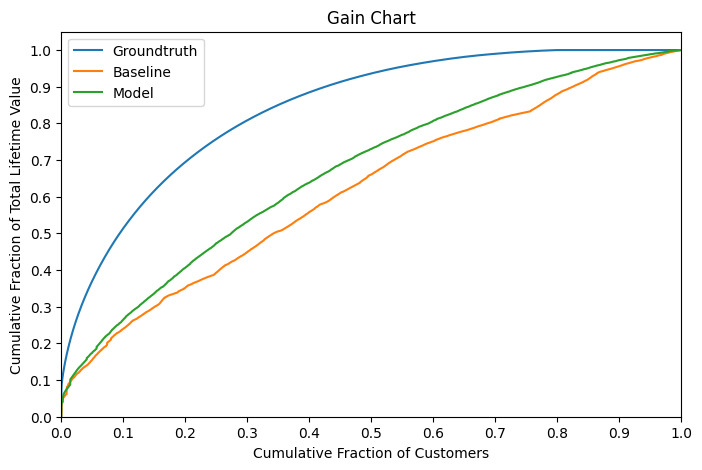

In [21]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='upper left')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart')

In [22]:
from lifetime_value_pytorch.metrics import gini_from_gain
gini = gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

D:\github_repo_forked\lifetime_value\lifetime_value_pytorch\metrics.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized = raw / raw[0]


,raw,normalized
lorenz,0.682247,1.000000
baseline,0.238694,0.349864
model,0.340313,0.498811


## 校准

In [23]:
from lifetime_value_pytorch.metrics import decile_stats
df_decile = decile_stats(y_eval, y_pred)
df_decile

D:\github_repo_forked\lifetime_value\lifetime_value_pytorch\metrics.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('decile').apply(_aggregate_fn)


,label_mean,pred_mean,normalized_rmse,normalized_mae,decile_mape
decile,,,,,
0,7.425931,6.918355,2.948807,1.082903,0.068352
1,12.288305,11.582898,2.357194,0.992921,0.057405
2,14.383371,14.639279,1.785164,0.985252,0.017792
3,18.144182,17.675922,1.734938,0.954301,0.025808
4,20.725856,21.165442,1.435640,0.946642,0.021210
5,24.807812,25.559408,1.330946,0.892192,0.030297
6,28.847532,29.541960,1.341119,0.871624,0.024072
7,33.920660,34.742550,1.470824,0.887375,0.024230
8,38.469446,41.506508,1.485676,0.917644,0.078947


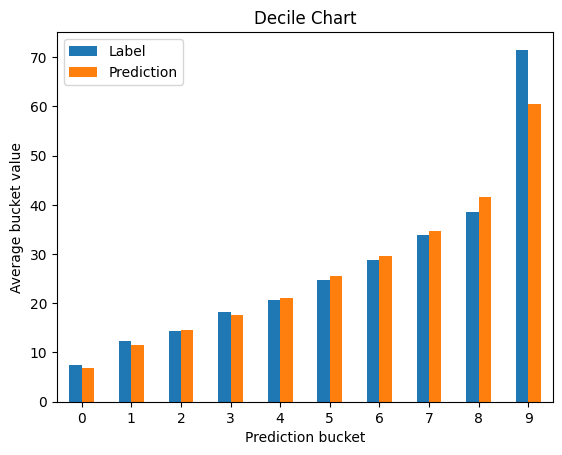

In [24]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left')

## 秩相关

In [25]:
def spearmanr(x1: Sequence[float], x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

np.float64(0.37559029314407644)

## All metrics

In [26]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_eval.mean(),
        'pred_mean': y_pred.mean(),
        'label_positive': np.mean(y_eval > 0),
        'decile_mape': df_decile['decile_mape'].mean(),
        'baseline_gini': gini['normalized'][1],
        'gini': gini['normalized'][2],
        'spearman_corr': spearman_corr,
    },
    index=[0])

C:\Users\jingyuan.hao\AppData\Local\Temp\ipykernel_30628\360493497.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'baseline_gini': gini['normalized'][1],
C:\Users\jingyuan.hao\AppData\Local\Temp\ipykernel_30628\360493497.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'gini': gini['normalized'][2],


In [27]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'label_positive',
    'decile_mape',
    'baseline_gini',
    'gini',
    'spearman_corr',
]]

,company,model,loss,label_mean,pred_mean,label_positive,decile_mape,baseline_gini,gini,spearman_corr
0,101410010,linear,ziln,27.041962,26.377834,0.801631,0.0501,0.349864,0.498811,0.37559


## Save


In [29]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, str(COMPANY))

In [30]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [31]:
output_file = os.path.join(output_path,
                           '{}_regression_{}.csv'.format(MODEL, LOSS))

In [32]:
df_metrics.to_csv(output_file, index=False)